# Library Import

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


In [70]:
import warnings
warnings.filterwarnings('ignore')

# Loading & Cleaning table

## Preview table

In [206]:
df = pd.read_csv('./covid_19_clean_28_Feb.csv', 
                         parse_dates=['Date'])
df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,Anhui,Mainland China,31.8257,117.2264,2020-01-22,1,0,0
1,Beijing,Mainland China,40.1824,116.4142,2020-01-22,14,0,0
2,Chongqing,Mainland China,30.0572,107.8740,2020-01-22,6,0,0
3,Fujian,Mainland China,26.0789,117.9874,2020-01-22,1,0,0
4,Gansu,Mainland China,36.0611,103.8343,2020-01-22,0,0,0


## Cleaning table and derivation

### Head preview after region filtering

In [5]:
df['Country/Region'] = df['Country/Region'].replace('Mainland China', 'China')
df[['Province/State']] = df[['Province/State']].fillna('NA')

In [203]:
ship = df[df['Province/State']=='Diamond Princess cruise ship']
df = df[df['Province/State']!='Diamond Princess cruise ship']

df2 = df.set_index('Country/Region').loc[['China','Italy','South Korea','Iran','Japan','Vietnam']].reset_index()
df2.info()
df2.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1332 entries, 0 to 1331
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Country/Region  1332 non-null   object        
 1   Province/State  1332 non-null   object        
 2   Lat             1332 non-null   float64       
 3   Long            1332 non-null   float64       
 4   Date            1332 non-null   datetime64[ns]
 5   Confirmed       1332 non-null   int64         
 6   Deaths          1332 non-null   int64         
 7   Recovered       1332 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 83.4+ KB


,Country/Region,Province/State,Lat,Long,Date,Confirmed,Deaths,Recovered
0,China,Anhui,31.8257,117.2264,2020-01-22,1,0,0
1,China,Beijing,40.1824,116.4142,2020-01-22,14,0,0
2,China,Chongqing,30.0572,107.8740,2020-01-22,6,0,0
3,China,Fujian,26.0789,117.9874,2020-01-22,1,0,0
4,China,Gansu,36.0611,103.8343,2020-01-22,0,0,0
5,China,Guangdong,23.3417,113.4244,2020-01-22,26,0,0
6,China,Guangxi,23.8298,108.7881,2020-01-22,2,0,0
7,China,Guizhou,26.8154,106.8748,2020-01-22,1,0,0
8,China,Hainan,19.1959,109.7453,2020-01-22,4,0,0
9,China,Hebei,38.0428,114.5149,2020-01-22,1,0,0


In [222]:
china = df2[df2['Country/Region']=='China']
non_china = df2[df2['Country/Region']!='China']

full_latest = df2[df2['Date'] == max(df2['Date'])].reset_index()
china_latest = full_latest[full_latest['Country/Region']=='China']
non_china_latest = full_latest[full_latest['Country/Region']!='China']

full_latest_grouped = full_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()
china_latest_grouped = china_latest.groupby('Province/State')['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()
non_china_latest_grouped = non_china_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()

new = df2.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']
new = new.sum().diff().reset_index()

mask = new['Country/Region'] != new['Country/Region'].shift(1)

new.loc[mask, 'Confirmed'] = np.nan
new.loc[mask, 'Deaths'] = np.nan
new.loc[mask, 'Recovered'] = np.nan

# EDA

## Latest count (27-Feb-2020) 

In [72]:
latest_count = df.groupby('Date')['Confirmed', 'Deaths', 'Recovered'].sum().sort_values('Date', ascending=False)

In [85]:
latest_count.head(1).style.background_gradient(axis=0, cmap='Paired')

,Confirmed,Deaths,Recovered
Date,,,
2020-02-27 00:00:00,82051,2810,33267


In [111]:
latest_count_country = full_latest_grouped[['Country/Region', 'Confirmed', 'Deaths', 'Recovered']]
latest_count_country = latest_count_country.sort_values(by='Confirmed', ascending=False).reset_index(drop=True)
latest_count_country.style.background_gradient(axis=0, cmap='Paired')

,Country/Region,Confirmed,Deaths,Recovered
0,China,78498,2744,32898
1,South Korea,1766,13,22
2,Italy,655,17,45
3,Iran,245,26,49
4,Japan,214,4,22
5,Vietnam,16,0,16


## Number of Cases & Deaths over time country-wise

In [135]:
overtime_count_country = df2.groupby(['Country/Region', 'Date'])['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()

fig = px.bar(overtime_count_country, x="Date", y="Confirmed", color='Country/Region', title='Cases', color_discrete_sequence = px.colors.sequential.Purp)
fig.show()

fig = px.bar(overtime_count_country, x="Date", y="Deaths", color='Country/Region', title='Deaths', color_discrete_sequence = px.colors.sequential.Burg)
fig.show()

## Number of Cases & Deaths over time country-wise except China

In [201]:
overtime_count_nonchina = non_china.groupby(['Country/Region', 'Date'])['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()

fig = px.bar(overtime_count_nonchina, x="Date", y="Confirmed", color='Country/Region', title='Cases', color_discrete_sequence = px.colors.sequential.Purp)
fig.show()

fig = px.bar(overtime_count_nonchina, x="Date", y="Deaths", color='Country/Region', title='Deaths', color_discrete_sequence = px.colors.sequential.Burg)
fig.show()

## Data of Diamond Princess Cruise (Japan):

In [205]:
ship

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered


## Ratio in Pairs over time (globally)

### Mortality Rate = Deaths / Confirmed

In [131]:
mr_avg = df['Deaths'].sum()/df['Confirmed'].sum()

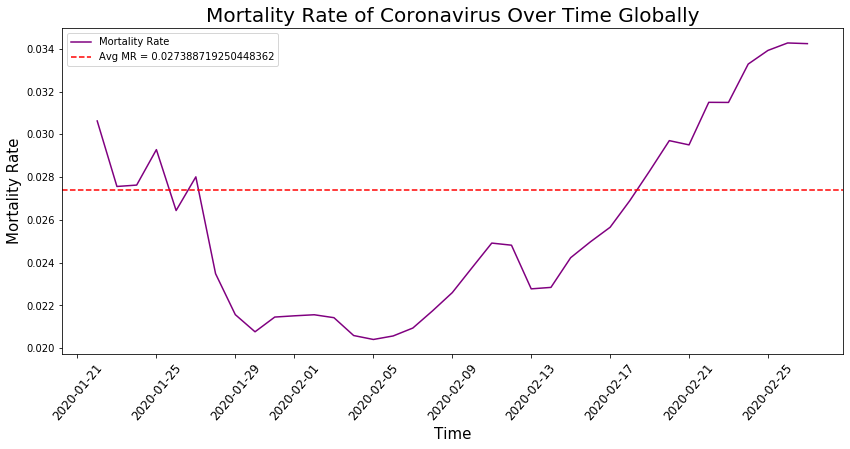

In [195]:
mr_ot = df.groupby(['Date'])['Deaths'].sum() / df.groupby(['Date'])['Confirmed'].sum()
mr_ot = mr_ot.to_frame().reset_index()

plt.figure(figsize=(14, 6))
plt.plot(mr_ot['Date'], mr_ot[0], color='purple')
plt.axhline(y = mr_avg,linestyle='--', color='red')
plt.title('Mortality Rate of Coronavirus Over Time Globally', size=20)
plt.legend(['Mortality Rate', 'Avg MR = '+str(mr_avg)])
plt.xlabel('Time', size=15)
plt.ylabel('Mortality Rate', size=15)
plt.xticks(rotation=50, size=12)
plt.show()


### Recovery Rate = Recovered / Confirmed

In [196]:
rr_avg = df['Recovered'].sum()/df['Confirmed'].sum()

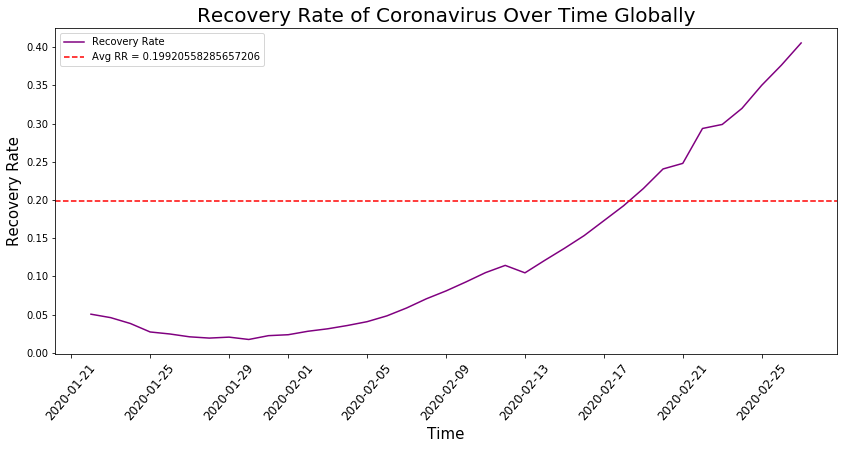

In [198]:
rr_ot = df.groupby(['Date'])['Recovered'].sum() / df.groupby(['Date'])['Confirmed'].sum()
rr_ot = rr_ot.to_frame().reset_index()

plt.figure(figsize=(14, 6))
plt.plot(rr_ot['Date'], rr_ot[0], color='purple')
plt.axhline(y = rr_avg,linestyle='--', color='red')
plt.title('Recovery Rate of Coronavirus Over Time Globally', size=20)
plt.legend(['Recovery Rate', 'Avg RR = '+str(rr_avg)])
plt.xlabel('Time', size=15)
plt.ylabel('Recovery Rate', size=15)
plt.xticks(rotation=50, size=12)
plt.show()


### Recovery per Deaths = Recovered / Deaths

In [199]:
rd_avg = df['Recovered'].sum()/df['Deaths'].sum()

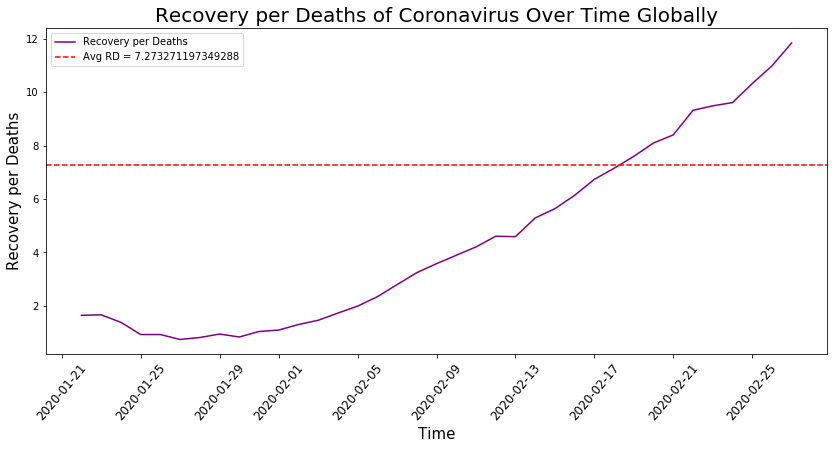

In [200]:
rd_ot = df.groupby(['Date'])['Recovered'].sum() / df.groupby(['Date'])['Deaths'].sum()
rd_ot = rd_ot.to_frame().reset_index()

plt.figure(figsize=(14, 6))
plt.plot(rd_ot['Date'], rd_ot[0], color='purple')
plt.axhline(y = rd_avg,linestyle='--', color='red')
plt.title('Recovery per Deaths of Coronavirus Over Time Globally', size=20)
plt.legend(['Recovery per Deaths', 'Avg RD = '+str(rd_avg)])
plt.xlabel('Time', size=15)
plt.ylabel('Recovery per Deaths', size=15)
plt.xticks(rotation=50, size=12)
plt.show()


## Number of new Confirmed Cases over time

### China

In [224]:
fig = px.bar(new[new['Country/Region']=='China'], x="Date", y="Confirmed", color='Country/Region',
             title='Number of new confirmed cases over time')
fig.show()

fig = px.bar(new[new['Country/Region']=='China'], x="Date", y="Deaths", color='Country/Region',
             title='Number of new deaths in China over time')
fig.show()



## Non-china

In [223]:
fig = px.bar(new[new['Country/Region']!='China'], x="Date", y="Confirmed", color='Country/Region',
             title='Number of new cases outside China everyday')
fig.show()

fig = px.bar(new[new['Country/Region']!='China'], x="Date", y="Deaths", color='Country/Region',
             title='Number of new deaths outside China everyday')
fig.show()

## Comparison with some prior pandemics (EBOLA, H1N1, SARS-CoV, MERS-Cov)

In [233]:
covid = latest_count.head(1)['Confirmed'][0]
covid_deaths = latest_count.head(1)['Deaths'][0]

In [234]:
sars_deaths = 774
h1n1_deaths = 19654
mers_deaths = 858
ebola_deaths = 11323

In [235]:
sars = 8096
h1n1 = 6724149
mers = 2494
ebola = 28646

### Number of confirmed Cases

In [248]:
fig = px.bar(x=['SARS 03-04', 'MERS 12-17','Ebola 14-16','CoVID 19-?'], y=[sars,mers,ebola,covid], title='Number of Confirmed Cases of some major pandemics recently', color_discrete_sequence = px.colors.sequential.Purp)
fig.show()

In [249]:
fig = px.bar(x=['SARS 03-04', 'MERS 12-17','Ebola 14-16','CoVID 19-?'], y=[sars_deaths,mers_deaths,ebola_deaths,covid_deaths], title='Number of Deaths of some major pandemics recently', color_discrete_sequence = px.colors.sequential.Burg)
fig.show()

In [252]:
fig = px.bar(x=['SARS 03-04', 'MERS 12-17','Ebola 14-16','CoVID 19-?'], y=[sars_deaths/sars,mers_deaths/mers,ebola_deaths/ebola,covid_deaths/covid], title='Mortality Rate of 5 major pandemics recently', color_discrete_sequence = px.colors.sequential.haline)
fig.show()